# Gender bias analysis

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import display, Markdown
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
from pathlib import Path

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

from utils.validation_helpers import load_models_from_directory
from utils.word_choice_helpers import get_all_words, attribute_words, target_words, check_rap_frequencies, check_model_existence, compare_gendered_word_similarities, gendered_pairs
from utils.visualisations_helpers import plot_gendered_average_similarity_by_model, plot_gendered_similarity_by_pair, display_gender_bias_compact_table, plot_gender_bias
from utils.analysis_helpers import GenderBiasWEATAnalyser

In [5]:
# Load corpus and models
with open("../data/processed_lyrics.pkl", "rb") as f:
    corpus = pickle.load(f)

print("Loading models...")
models = load_models_from_directory('../models')

print(f"\nLoaded {len(models)} models:")
for model_name, model in models.items():
    vocab_size = len(model.wv.index_to_key)
    vector_size = model.vector_size
    # Calculate the total number of tokens (sum of word counts)
    total_tokens = sum(model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key)
    print(f"  {model_name}:\n      Vocabulary size: {vocab_size} \n      {total_tokens:,} tokens \n      Vector size: {vector_size}")

Loading models...
Loaded model: frWac_200_cbow
Loaded model: frRap_200_skip
Loaded model: frWiki_1000_cbow
Loaded model: frWac_200_skip
Loaded model: frWiki_1000_skip
Loaded model: frRap_200_cbow
Loaded model: frRap_100_skip
Loaded model: frRap_100_cbow

Loaded 8 models:
  frWac_200_cbow:
      Vocabulary size: 155562 
      12,099,845,703 tokens 
      Vector size: 200
  frRap_200_skip:
      Vocabulary size: 26149 
      3,835,340 tokens 
      Vector size: 200
  frWiki_1000_cbow:
      Vocabulary size: 66274 
      2,196,154,675 tokens 
      Vector size: 1000
  frWac_200_skip:
      Vocabulary size: 155562 
      12,099,845,703 tokens 
      Vector size: 200
  frWiki_1000_skip:
      Vocabulary size: 66274 
      2,196,154,675 tokens 
      Vector size: 1000
  frRap_200_cbow:
      Vocabulary size: 26149 
      3,835,340 tokens 
      Vector size: 200
  frRap_100_skip:
      Vocabulary size: 26149 
      3,835,340 tokens 
      Vector size: 100
  frRap_100_cbow:
      Vocabulary si

## Checking minimum frequency of words in attribute and target word sets

In [ ]:
all_words = get_all_words(attribute_words, target_words)

# Frequency of words in the corpus (minimum frequency of 5)
freq_df = check_rap_frequencies(corpus, all_words)

if min(freq_df['frequency']) < 5:
    print("Some words have a frequency lower than 5. Check the frequency DataFrame.")
else:
    print("All words have a frequency of at least 5.")

exist_df = check_model_existence(models, all_words)

# For each model, print words that don't exist
for model_name in [col for col in exist_df.columns if col != 'word']:
    missing_words = exist_df[~exist_df[model_name]]['word'].tolist()
    print(f"\n{model_name}: {len(missing_words)} missing words")
    print(", ".join(missing_words))

## Checking for cosine similarity of gendered pairs

Model Statistics:
              model      mean       min       max  count
0    frRap_100_cbow  0.248422  0.047463  0.493591      9
1    frRap_100_skip  0.440968  0.318316  0.656683      9
2    frRap_200_cbow  0.287834  0.095203  0.594770      9
3    frRap_200_skip  0.404201  0.211882  0.664060      9
4    frWac_200_cbow  0.549047  0.414374  0.716506      9
5    frWac_200_skip  0.691762  0.540581  0.850836      9
6  frWiki_1000_cbow  0.034638 -0.130061  0.314369      9
7  frWiki_1000_skip  0.365024  0.196947  0.535211      9
Figure saved to ../figs/gendered_words_similarity/average_similarity_by_model.png


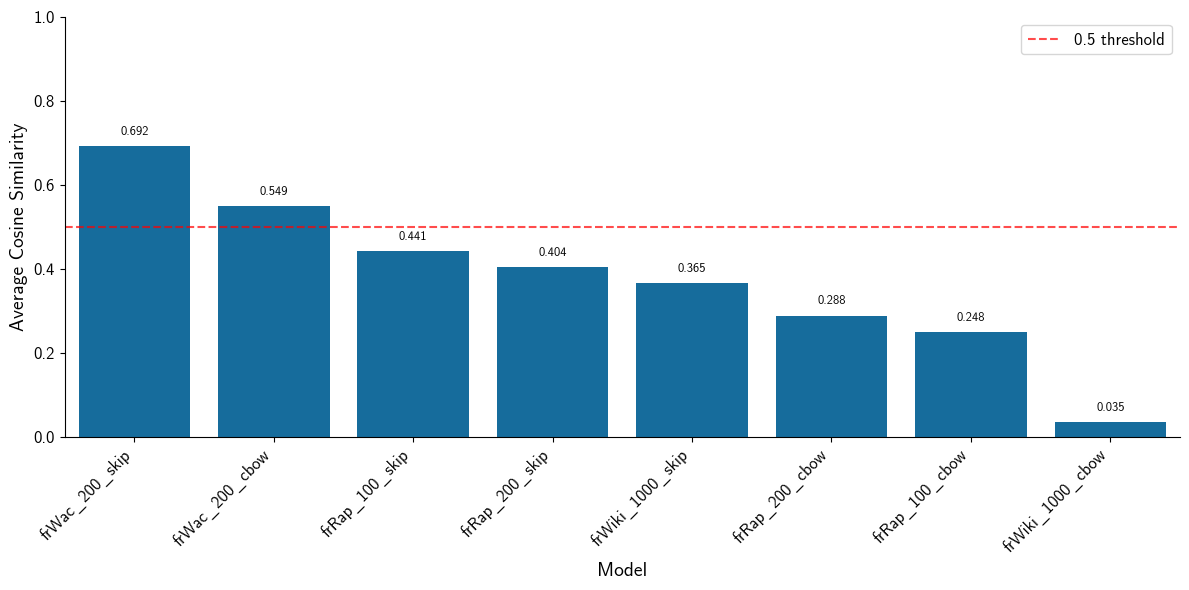

Figure saved to ../figs/gendered_words_similarity/similarity_by_pair.png


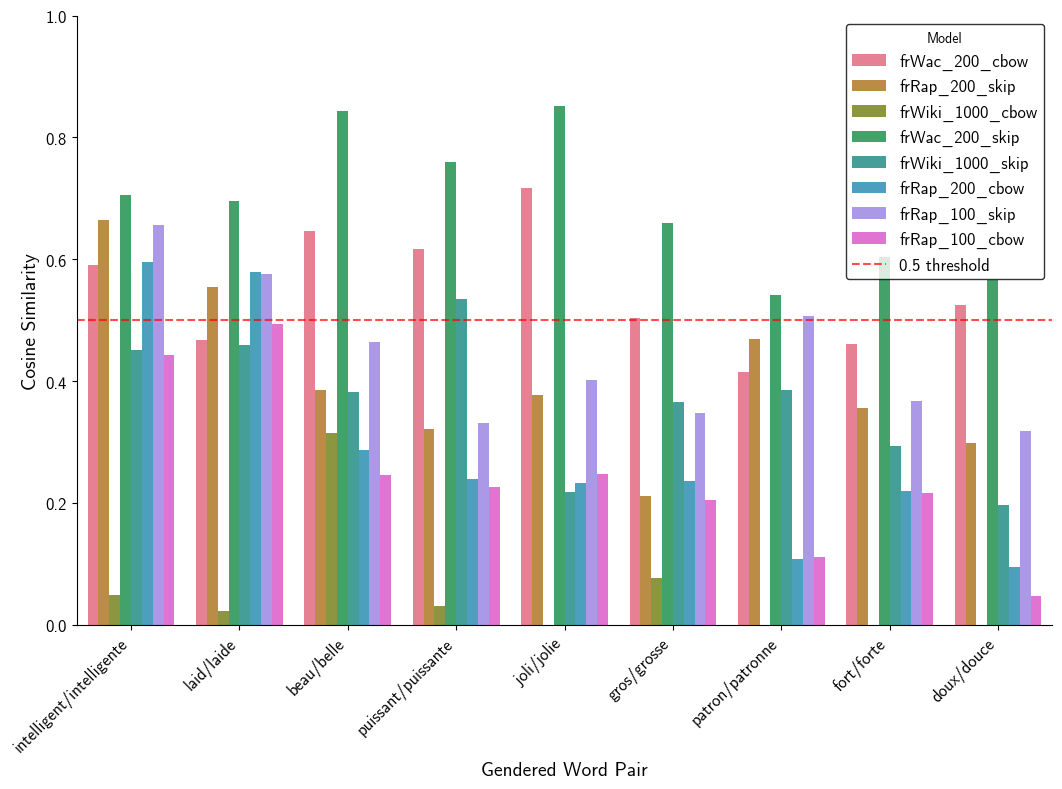

In [7]:
gendered_similarity_df = compare_gendered_word_similarities(models, gendered_pairs)

# Plot average similarity by model
plot_gendered_average_similarity_by_model(gendered_similarity_df, save_path="../figs/gendered_words_similarity/average_similarity_by_model.png")

# Plot similarity by pair, showing the 10 pairs with most variation
plot_gendered_similarity_by_pair(gendered_similarity_df, save_path="../figs/gendered_words_similarity/similarity_by_pair.png")

## Word Embedding Association Test (WEAT)
A popular method of testing for the presence of gender bias in word embeddings is the Word Embedding Association Test (WEAT), created by Caliskan et al. (2017) [1] and subsequently improved on by Garg et al. (2018) [2] Chaloner & Maldonado (2019) [3] and Betti et al. (2023)[4]. 

1. **Define word sets**
- Two target word sets (X, Y) representing concept categories. I gather them from Caliskan et al. (2017), Garg et al. (2018), Chaloner & Maldonado (2019), and Betti et al. (2023).
    - *Career vs. Family*
    - *Maths / Science vs. Arts* 
    - Differences on *personal descriptions in terms of intelligence vs. appearance*
    - Physical or emotional *strength vs. weakness*

- Two attribute word sets (M, F) representing male and female concepts

The null hypothesis (H0) is that there is no difference between $M$ and $F$ in terms of their relative cosine similarity to $X$ and $Y$.

2. **Calculate association measure for each target word, and test statistic**

I first calculate the **measure of association** between target word $w$, and the attribute words in $M$ and $F$. 

\begin{equation}
s(w, M, F) = \frac{1}{|M|} \sum_{m\in M} \cos(\vec{w}, \vec{m}) - \frac{1}{|F|} \sum_{f\in F} \cos(\vec{w}, \vec{f})
\end{equation}

Then, I compute the following **test statistic**

\begin{equation}
s(X, Y, M, F) = \sum_{x\in X} s(x, M, F) - \sum_{y\in Y} s(y, M, F).
\end{equation}

H0 is tested in Caliskan et al. (2017) through a permutation test, where all words in $X$ and $Y$ are partitioned in alternative target lists $\hat{X}$ and $\hat{Y}$ exhaustively, and the one-sided p-value $p[s(\hat{X}, \hat{Y}, M, F) > s(X, Y, M, F)]$ is computed. This value represents the proportion of partition permutations in which the test statistic $s(\hat{X}, \hat{Y}, M, F)$ is greater tham the observed test statistic $s(X, Y, M, F)$, i.e., the probability that H0 is true, and that there is no difference between $X$ and $Y$ in relation to $M$ and $F$.

Similarly to Betti et al. (2023), I use randomisation tests with a maximimum of 1,000 iterations instead of the exhaustive permutation tests.

3. **Calculate effect size using Cohen's d**

\begin{equation}
d = \frac{\text{mean}_{x \in X} s(x, M, F) - \text{mean}_{y \in Y} s(y, M, F)}{SD_{\textbf{pooled}_{w \in X \cup Y}} s(w, M, F)}
\end{equation}

where $SD_{\textbf{pooled}}$ is calculated as:

\begin{equation}
\text{SD}_{\text{pooled}} = \sqrt{\frac{(\text{SD}_X^2 + \text{SD}_Y^2)}{2}}
\end{equation}

where $\text{SD}_X$ is the standard deviation of the association measures $s(x, M, F)$ for all $x \in X$, and $\text{SD}_Y$ is the standard deviation of the association measures $s(y, M, F)$ for all $y \in Y$.

Based on this formulation, a positive effect size would indicate that the words in $X$ are more similar to the words in $M$ than in $F$, and the words in $Y$ are more similar to the words in $F$ than in $M$.

-----
[1] Caliskan, A., Bryson, J. J., & Narayanan, A. (2017). Semantics derived automatically from language corpora contain human-like biases. Science, 356(6334), 183–186. https://doi.org/10.1126/science.aal4230

[2] Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. Proceedings of the National Academy of Sciences, 115(16), E3635–E3644. https://doi.org/10.1073/pnas.1720347115

[3] Chaloner, K., & Maldonado, A. (2019). Measuring Gender Bias in Word Embeddings across Domains and Discovering New Gender Bias Word Categories. In M. R. Costa-jussà, C. Hardmeier, W. Radford, & K. Webster (Eds.), Proceedings of the First Workshop on Gender Bias in Natural Language Processing (pp. 25–32). Association for Computational Linguistics. https://doi.org/10.18653/v1/W19-3804

[4] Betti, L., Abrate, C., & Kaltenbrunner, A. (2023). Large scale analysis of gender bias and sexism in song lyrics. EPJ Data Science, 12(1), Article 1. https://doi.org/10.1140/epjds/s13688-023-00384-8


In [ ]:
WEAT_results = {}

# For each loaded model in models dict
for model_name, model in models.items():
    # Initialize the WEAT analyser (from utils.analysis_helpers)
    WEAT_analyser = GenderBiasWEATAnalyser(model)

    print(f"\nRunning WEAT analysis for {model_name}...")

    # Run the WEAT analysis for all gender bias categories and save results
    WEAT_results[model_name] = WEAT_analyser.analyse_all_categories(n_permutations=1000)

    # Save the permutation plots
    WEAT_analyser.visualize_permutation_tests(save_path=f"../figs/WEAT/{model_name}permutation_tests.png")

WEAT_results_df = pd.DataFrame(WEAT_results).T


Running WEAT analysis for frWac_200_cbow...
Analysing category: B1_career_family
  P-value: 0.0070, Effect size: 1.3070
  X words in vocab: 10/10
  Y words in vocab: 8/8
  Interpretation: Category X words are more associated with male attributes (Effect size 1.306991007401859, statistically significant, p=0.0070)
Analysing category: B2_mathsci_arts
  P-value: 0.0010, Effect size: 2.1728
  X words in vocab: 7/7
  Y words in vocab: 6/6
  Interpretation: Category X words are more associated with male attributes (Effect size 2.172760588395746, statistically significant, p=0.0010)
Analysing category: B3_intel_appearance
  P-value: 0.0290, Effect size: 0.8320
  X words in vocab: 9/9
  Y words in vocab: 12/12
  Interpretation: Category X words are more associated with male attributes (Effect size 0.8320090010327487, statistically significant, p=0.0290)
Analysing category: B4_strength_weakness
  P-value: 0.0270, Effect size: 1.0926
  X words in vocab: 6/6
  Y words in vocab: 7/7
  Interpretat

In [9]:
gender_bias_results_md = display_gender_bias_compact_table(WEAT_results_df)

display(Markdown(gender_bias_results_md))

| Model            | Career-Family         | Math/Science-Arts     | Intelligence-Appearance   | Strength-Weakness     |
|:-----------------|:----------------------|:----------------------|:--------------------------|:----------------------|
| frWac_200_cbow   | **ES=1.307, p=0.007** | **ES=2.173, p=0.001** | **ES=0.832, p=0.029**     | **ES=1.093, p=0.027** |
| frRap_200_skip   | ES=0.679, p=0.097     | ES=0.521, p=0.178     | **ES=1.221, p=0.007**     | ES=-0.091, p=0.560    |
| frWiki_1000_cbow | **ES=1.043, p=0.028** | ES=0.655, p=0.136     | ES=-0.150, p=0.629        | ES=0.403, p=0.252     |
| frWac_200_skip   | **ES=1.778, p=0.002** | **ES=1.445, p=0.008** | **ES=1.196, p=0.007**     | **ES=1.526, p=0.006** |
| frWiki_1000_skip | **ES=1.817, p=0.001** | **ES=2.001, p=0.001** | ES=0.328, p=0.227         | ES=0.030, p=0.450     |
| frRap_200_cbow   | ES=0.281, p=0.288     | ES=0.821, p=0.080     | **ES=0.934, p=0.020**     | ES=-0.107, p=0.562    |
| frRap_100_skip   | **ES=0.866, p=0.045** | ES=0.940, p=0.057     | **ES=1.354, p=0.005**     | ES=0.010, p=0.454     |
| frRap_100_cbow   | ES=0.218, p=0.325     | ES=0.880, p=0.070     | **ES=1.080, p=0.009**     | ES=0.006, p=0.498     |

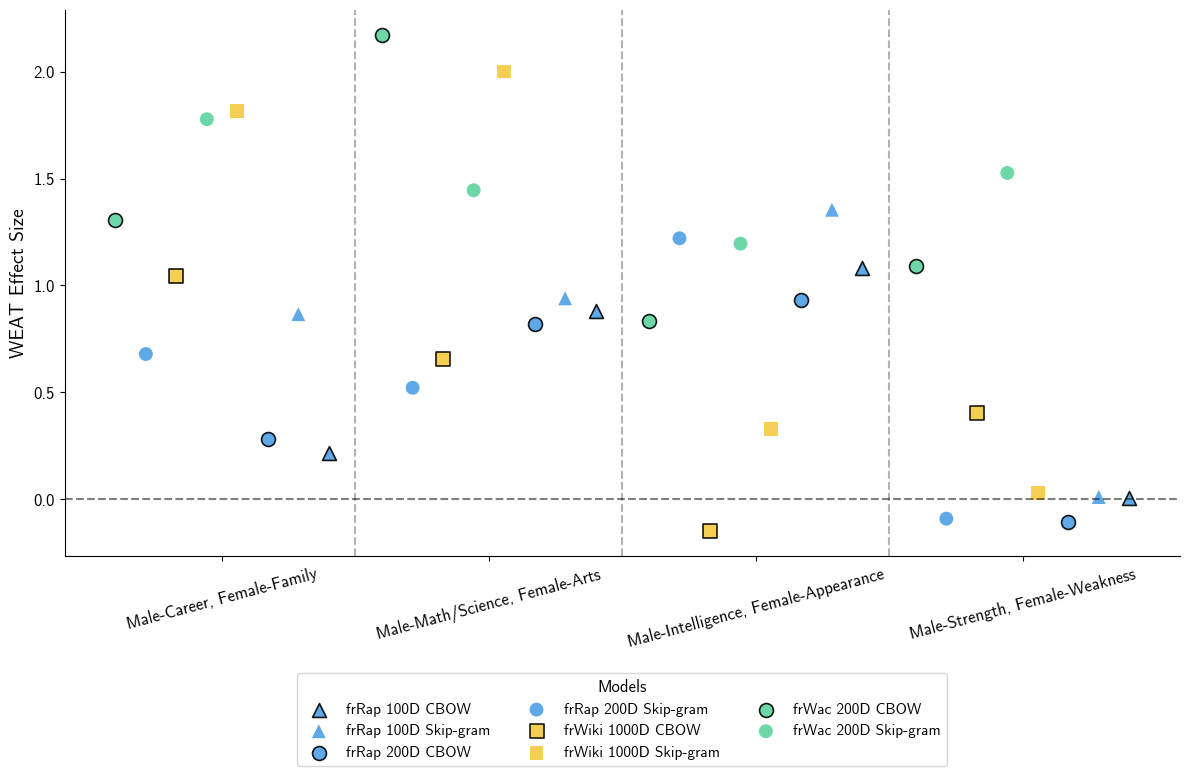

In [ ]:
fig = plot_gender_bias(WEAT_results_df, save_path="../figs/WEAT/WEAT_plot.png")
plt.show()

## (Prototype) Sliced Word Embedding Association Test (SWEAT)

In [ ]:
from utils.analysis_helpers import GenderBiasSWEATAnalyser

sweat_analyzer = GenderBiasSWEATAnalyser(
    corpus1_embeddings=models['frRap_non_lemma_skipgram_200_cut5_win5'],  # French Rap model
    corpus2_embeddings=models['frWiki_no_lem_no_postag_no_phrase_1000_skip_cut100'],  # French Wiki model
    corpus1_name="French Rap",
    corpus2_name="French Wiki"
)

results = sweat_analyzer.analyze_all_categories(target_words, attribute_words)